In [233]:
# ! pip install ipywidgets
# ! pip install implicit 
# ! pip install scikit-surprise

# Матричная факторизация в рекомендательных системах

## План лекции:
1. Введение и мотивация
2. Теория матричной факторизации  
3. Различные алгоритмы 
4. Неявные отзывы
5. Практика 
6. Сравнение методов



## Часть 1. Проблема рекомендательных систем

Представьте, что вы запускаете онлайн-кинотеатр

**Как рекомендовать фильмы?**

In [234]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['axes.facecolor'] = 'none'
mpl.rcParams['savefig.facecolor'] = 'none'
mpl.rcParams['savefig.transparent'] = True
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import implicit
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

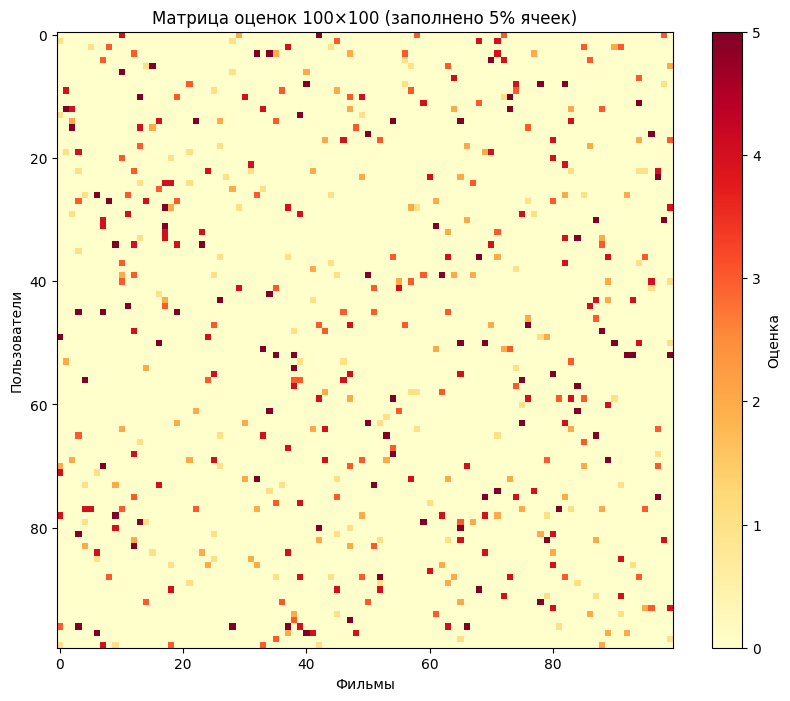

Заполненность матрицы: 4.9%
Количество пропусков: 9,507


In [235]:
np.random.seed(42)
large_matrix = np.zeros((100, 100))

mask = np.random.random((100, 100)) < 0.05
large_matrix[mask] = np.random.randint(1, 6, size=mask.sum())

plt.figure(figsize=(10, 8))
plt.imshow(large_matrix, cmap='YlOrRd', norm=colors.Normalize(vmin=0, vmax=5))
plt.colorbar(label='Оценка')
plt.title('Матрица оценок 100×100 (заполнено 5% ячеек)')
plt.xlabel('Фильмы')
plt.ylabel('Пользователи')
plt.show()

fill_percentage = np.count_nonzero(large_matrix) / large_matrix.size * 100
print(f"Заполненность матрицы: {fill_percentage:.1f}%")
print(f"Количество пропусков: {large_matrix.size - np.count_nonzero(large_matrix):,}")

- Всего возможных оценок: 100 × 100 = 10,000

- Заполнено всего: 500 оценок

- 95% матрицы - это пропуски

## Проблемы современных рекомендательных систем

### 1. Проблема разреженности
- Пользователи оценивают малую часть объектов
- Матрица оценок заполнена на 1-5%
- Сложно найти похожих пользователей/объектов

### 2. Проблема масштаба
- Миллионы пользователей × миллионы объектов
- Гигантские объемы данных
- Вычислительная сложность

### 3. Проблема "холодного старта"
- Новые пользователи без истории
- Новые объекты без оценок
- Как делать персонализированные рекомендации?

In [236]:
R = np.array([
    [5, 3, 0, 0, 0, 1, 0, 0],
    [4, 0, 0, 0, 0, 1, 0, 0],  
    [1, 1, 0, 0, 0, 5, 0, 0],
    [1, 0, 0, 0, 0, 4, 0, 0],
    [0, 1, 5, 0, 0, 4, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

movies = ['Брат', 'Ирония судьбы', 'Движение вверх', 'Криминальное чтиво', 
          'Легенда №17', 'Москва слезам не верит', 'Служебный роман', 'Война и мир']
users = ['Анна', 'Борис', 'Виктор', 'Галина', 'Дмитрий', 'Новый-1', 'Новый-2']

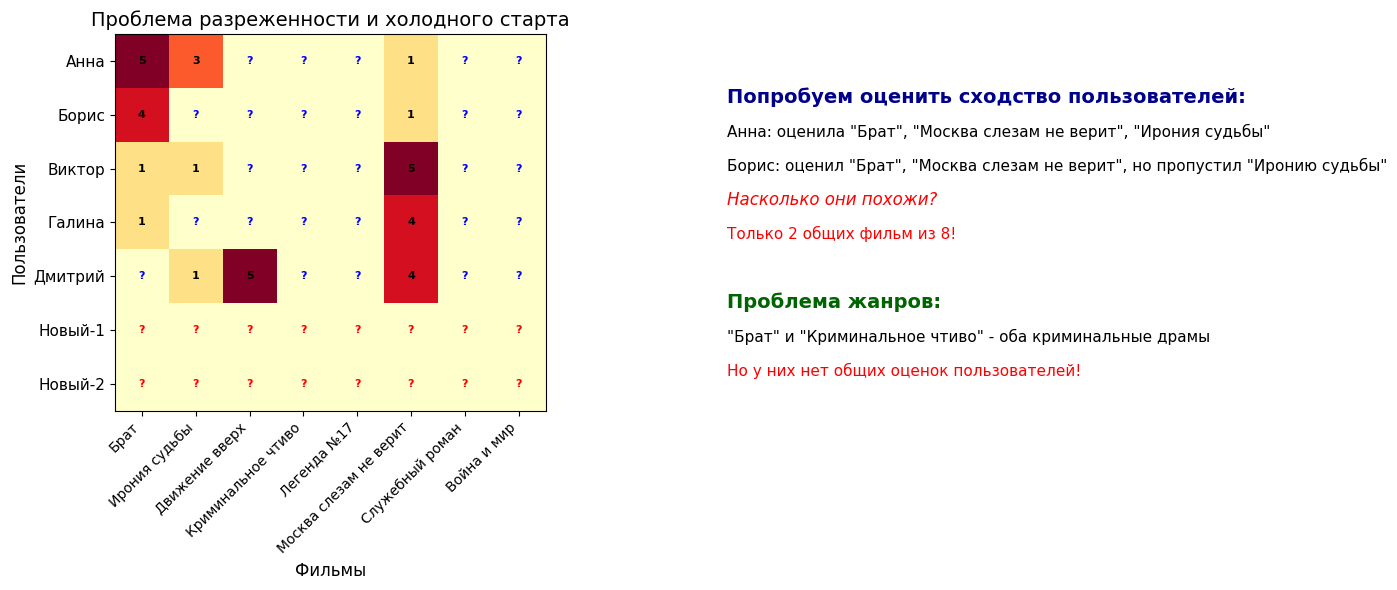

In [237]:
def demonstrate_challenges(ratings, movies, users):
    # матрица оценок  киносервиса
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    im1 = ax1.imshow(ratings, cmap='YlOrRd', norm=colors.Normalize(vmin=0, vmax=5))
    ax1.set_title('Проблема разреженности и холодного старта', fontsize=14)
    ax1.set_xticks(range(len(movies)))
    ax1.set_xticklabels(movies, rotation=45, ha='right', fontsize=10)
    ax1.set_yticks(range(len(users)))
    ax1.set_yticklabels(users, fontsize=11)
    ax1.set_ylabel('Пользователи', fontsize=12)
    ax1.set_xlabel('Фильмы', fontsize=12)
    
    for i in range(ratings.shape[0]):
        for j in range(ratings.shape[1]):
            if ratings[i, j] == 0:
                ax1.text(j, i, '?', ha='center', va='center', fontsize=8, 
                        color='red' if i >= 5 else 'blue', fontweight='bold')
            else:
                ax1.text(j, i, ratings[i, j], ha='center', va='center', fontsize=8, 
                        color='black', fontweight='bold')
    
    ax2.text(0.1, 0.8, 'Попробуем оценить сходство пользователей:', fontsize=14, 
             fontweight='bold', color='darkblue')
    ax2.text(0.1, 0.7, 'Анна: оценила "Брат", "Москва слезам не верит", "Ирония судьбы"', fontsize=11)
    ax2.text(0.1, 0.6, 'Борис: оценил "Брат", "Москва слезам не верит", но пропустил "Иронию судьбы"', fontsize=11) 
    ax2.text(0.1, 0.5, 'Насколько они похожи?', fontsize=12, style='italic', color='red')
    ax2.text(0.1, 0.4, 'Только 2 общих фильм из 8!', fontsize=11, color='red')
    
    ax2.text(0.1, 0.2, 'Проблема жанров:', fontsize=14, fontweight='bold', color='darkgreen')
    ax2.text(0.1, 0.1, '"Брат" и "Криминальное чтиво" - оба криминальные драмы', fontsize=11)
    ax2.text(0.1, 0.0, 'Но у них нет общих оценок пользователей!', fontsize=11, color='red')
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.1, 1)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    

demonstrate_challenges(R, movies, users)

✓ Разреженность: 85% пропусков в данных  
✓ Холодный старт: 2 новых пользователя без истории  
✓ Похожесть: мало общих оценок для сравнения пользователей  
✓ Жанровая схожесть: фильмы могут быть похожи, но нет данных для анализа  

### Традиционные подходы и их ограничения

1. Популярные фильмы
```
# просто рекомендовать самое популярное
popular_items = ["Брат", "Москва слезам не верит", "Ирония судьбы"]
```
Проблема: нет персонализации, всегда рекомендуются хиты 

2. Коллаборативная фильтрация (KNN)
```
# найти похожих пользователей
similar_users = find_similar(current_user, all_users)
```
**Проблема:** масштабируемость, разреженность, "пузырь фильтров" 

3. Контентная фильтрация  
```
# рекомендовать по жанрам и режиссерам
recommend_similar_genre(user_liked_movies)
```
**Проблема:** нет учета реального поведения пользователей 

## **Часть 2: Теория матричной факторизации**


### Основная идея:
Вместо работы с гигантской разреженной матрицей, находим скрытые (латентные) признаки:

**До:**
```
Пользователь × Фильмы (гигантская разреженная матрица)
```

**После:**
```
Пользователь × Признаки  +  Фильмы × Признаки (компактные плотные матрицы)
```

### Аналогия:

Вместо обработки всех пар пользователь-фильм, мы находим латентные представления:
- **Факторы пользователей**: отражают вкусовые предпочтения 
- **Факторы фильмов**: описывают жанровые характеристики

Теперь можно предсказать, понравится ли "Брат-2" человеку, которому нравится фильм "Брат"!
### Теория матричной факторизации

### Основная математическая постановка

Имеем матрицу оценок **R** размером `m × n`:
- `m` пользователей
- `n`  фильмов  
- `r_ui` - оценка пользователя `u` фильму `i`

Хотим найти матрицы **P** (`m × k`) и **Q** (`n × k`) такие, что:

```
R ≈ P × Qᵀ


где `k` - размерность латентного пространства (обычно 20-100)
```



#### **Исходное уравнение:**
```
R ≈ P × Qᵀ
```

где:
- **R** - матрица оценок (пользователи × фильмы)
- **P** - матрица пользователей (пользователи × признаки)  
- **Q** - матрица фильмов (фильмы × признаки)
- **Qᵀ** - транспонированная матрица фильмов (фильмы × признаки)


#### **Каждый элемент  вычисляется как:**


$$
R_{\text{reconstructed}}[i,j] = P[i] \cdot Q[j] = \sum_{k} P_{i,k} \times Q_{j,k}
$$

где:

- $ P[i] $ — вектор предпочтений (вкусов) пользователя $ i $,
- $ Q[j] $ — вектор характеристик (фич) фильма $ j $,
- Скалярное произведение $\sum_k P_{i,k} Q_{j,k}$ показывает степень совпадения вкусов пользователя с характеристиками фильма.


In [238]:
P = np.array([  # User factors - вкусы пользователей
        [0.8, 0.2, 0.1],  # Анна: криминал=0.8, комедия=0.2, драма=0.1
        [0.7, 0.1, 0.1],  # Борис: криминал=0.7, комедия=0.1, драма=0.1
        [0.1, 0.1, 0.9],  # Виктор: криминал=0.1, комедия=0.1, драма=0.9
        [0.2, 0.1, 0.8],  # Галина: криминал=0.2, комедия=0.1, драма=0.8
        [0.1, 0.3, 0.7],  # Дмитрий: криминал=0.1, комедия=0.3, драма=0.7
        [0.5, 0.3, 0.2],  # Новый-1: средние предпочтения
        [0.3, 0.4, 0.3],  # Новый-2: средние предпочтения
    ])
    
Q = np.array([  # Item factors - характеристики фильмов
        [0.9, 0.1, 0.1],  # Брат: криминал=0.9, комедия=0.1, драма=0.1
        [0.1, 0.8, 0.1],  # Ирония судьбы: криминал=0.1, комедия=0.8, драма=0.1
        [0.2, 0.1, 0.8],  # Движение вверх: криминал=0.2, комедия=0.1, драма=0.8
        [0.8, 0.1, 0.2],  # Криминальное чтиво: криминал=0.8, комедия=0.1, драма=0.2
        [0.1, 0.2, 0.8],  # Легенда №17: криминал=0.1, комедия=0.2, драма=0.8
        [0.1, 0.1, 0.9],  # Москва слезам не верит: криминал=0.1, комедия=0.1, драма=0.9
        [0.1, 0.7, 0.3],  # Служебный роман: криминал=0.1, комедия=0.7, драма=0.3
        [0.1, 0.1, 0.9],  # Война и мир: криминал=0.1, комедия=0.1, драма=0.9
    ])
    

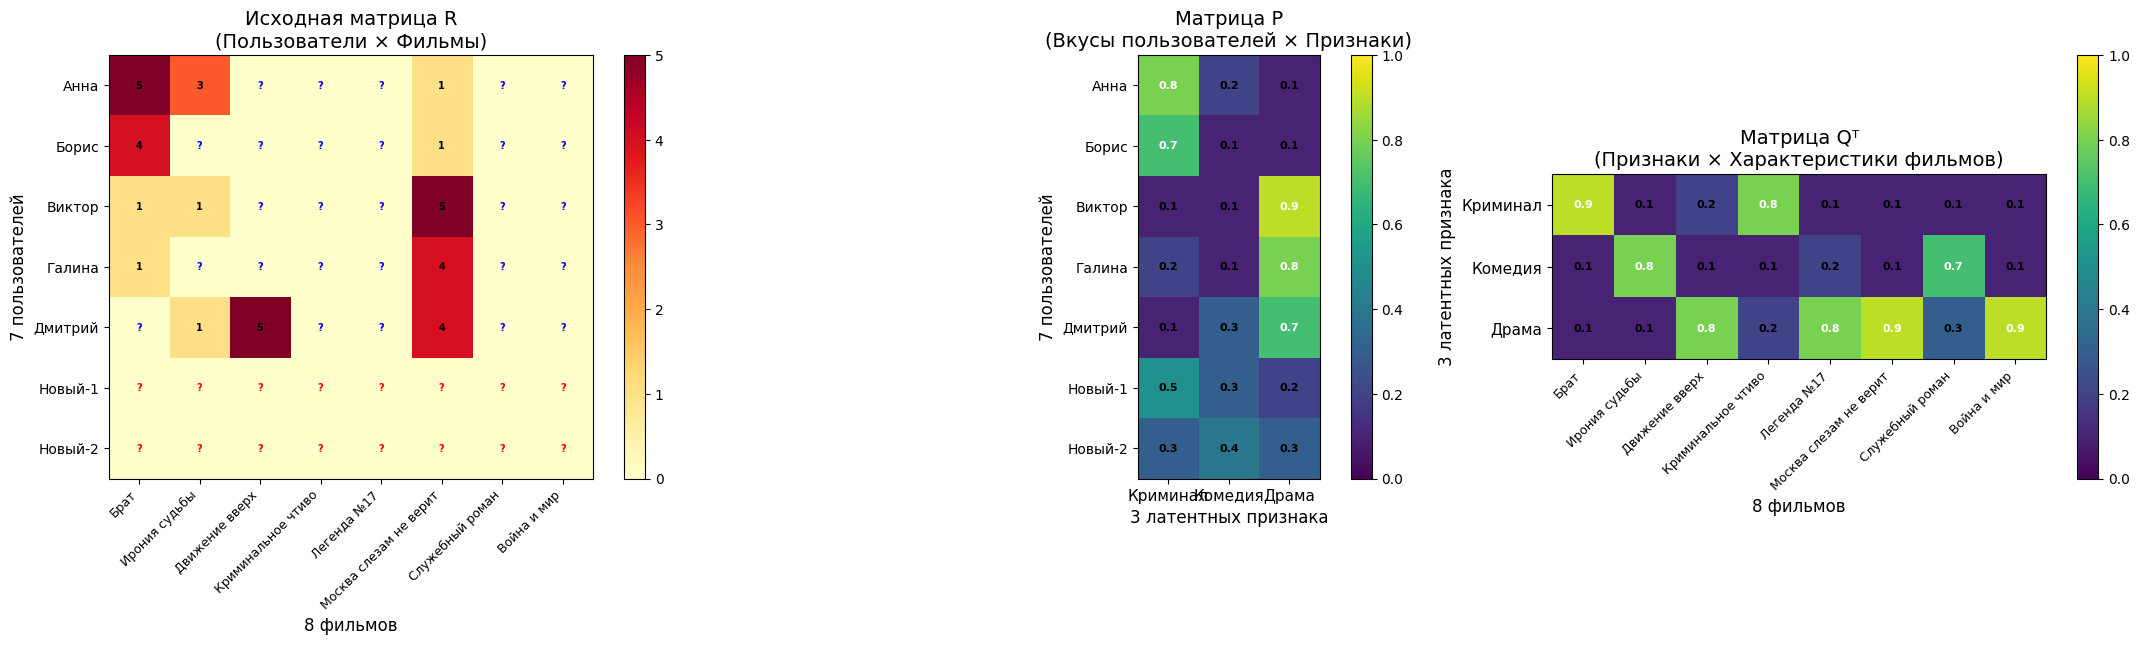

ВОССТАНОВЛЕННАЯ МАТРИЦА ОЦЕНОК P × Qᵀ:


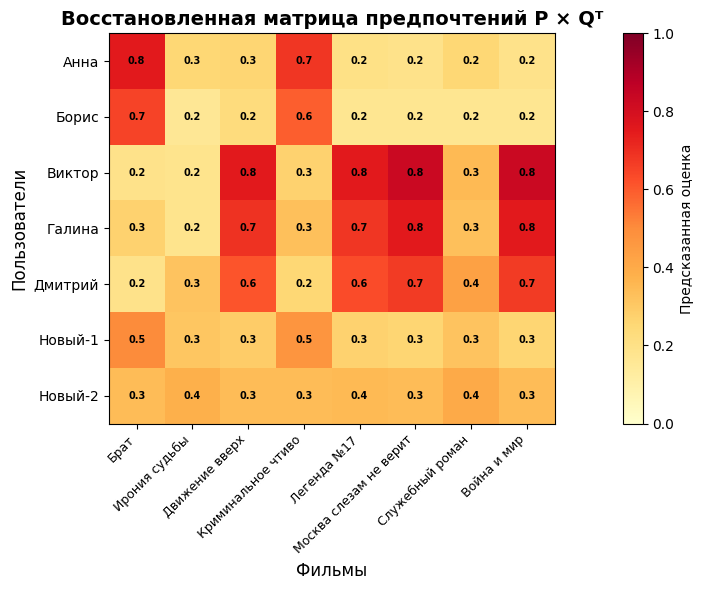

array([[0.75, 0.25, 0.26, 0.68, 0.2 , 0.19, 0.25, 0.19],
       [0.65, 0.16, 0.23, 0.59, 0.17, 0.17, 0.17, 0.17],
       [0.19, 0.18, 0.75, 0.27, 0.75, 0.83, 0.35, 0.83],
       [0.27, 0.18, 0.69, 0.33, 0.68, 0.75, 0.33, 0.75],
       [0.19, 0.32, 0.61, 0.25, 0.63, 0.67, 0.43, 0.67],
       [0.5 , 0.31, 0.29, 0.47, 0.27, 0.26, 0.32, 0.26],
       [0.34, 0.38, 0.34, 0.34, 0.35, 0.34, 0.4 , 0.34]])

In [239]:
def demonstrate_factorization(R, movies, users, P, Q):
    # восстановленная матрица: (пользователи × фильмы) = (7×3) @ (3×8)
    R_reconstructed = P @ Q.T
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    
    im1 = axes[0].imshow(R, cmap='YlOrRd', vmin=0, vmax=5)
    axes[0].set_title('Исходная матрица R\n(Пользователи × Фильмы)', fontsize=14)
    axes[0].set_ylabel('7 пользователей', fontsize=12)
    axes[0].set_xlabel('8 фильмов', fontsize=12)
    axes[0].set_xticks(range(len(movies)))
    axes[0].set_xticklabels(movies, rotation=45, ha='right', fontsize=9)
    axes[0].set_yticks(range(len(users)))
    axes[0].set_yticklabels(users, fontsize=10)
    plt.colorbar(im1, ax=axes[0])
    
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if R[i, j] == 0:
                axes[0].text(j, i, '?', ha='center', va='center', fontsize=7, 
                            color='red' if i >= 5 else 'blue', fontweight='bold')
            else:
                axes[0].text(j, i, f'{R[i, j]}', ha='center', va='center', fontsize=7, 
                            color='black', fontweight='bold')
    
    im2 = axes[1].imshow(P, cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('Матрица P\n(Вкусы пользователей × Признаки)', fontsize=14)
    axes[1].set_ylabel('7 пользователей', fontsize=12)
    axes[1].set_xlabel('3 латентных признака', fontsize=12)
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_xticklabels(['Криминал', 'Комедия', 'Драма'], fontsize=11)
    axes[1].set_yticks(range(len(users)))
    axes[1].set_yticklabels(users, fontsize=10)
    plt.colorbar(im2, ax=axes[1])
    
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            axes[1].text(j, i, f'{P[i, j]:.1f}', ha='center', va='center', 
                        fontweight='bold', fontsize=8, 
                        color='white' if P[i, j] > 0.5 else 'black')
    
    im3 = axes[2].imshow(Q.T, cmap='viridis', vmin=0, vmax=1)
    axes[2].set_title('Матрица Qᵀ\n(Признаки × Характеристики фильмов)', fontsize=14)
    axes[2].set_ylabel('3 латентных признака', fontsize=12)
    axes[2].set_xlabel('8 фильмов', fontsize=12)
    axes[2].set_xticks(range(len(movies)))
    axes[2].set_xticklabels(movies, rotation=45, ha='right', fontsize=9)
    axes[2].set_yticks([0, 1, 2])
    axes[2].set_yticklabels(['Криминал', 'Комедия', 'Драма'], fontsize=11)
    plt.colorbar(im3, ax=axes[2])
    
    for i in range(Q.T.shape[0]):
        for j in range(Q.T.shape[1]):
            axes[2].text(j, i, f'{Q.T[i, j]:.1f}', ha='center', va='center', 
                        fontweight='bold', fontsize=8, 
                        color='white' if Q.T[i, j] > 0.5 else 'black')
    
    plt.tight_layout()
    plt.show()
    
    print("ВОССТАНОВЛЕННАЯ МАТРИЦА ОЦЕНОК P × Qᵀ:")
    
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(R_reconstructed, cmap='YlOrRd', vmin=0, vmax=1)
    ax.set_title('Восстановленная матрица предпочтений P × Qᵀ', fontsize=14, fontweight='bold')
    ax.set_ylabel('Пользователи', fontsize=12)
    ax.set_xlabel('Фильмы', fontsize=12)
    ax.set_xticks(range(len(movies)))
    ax.set_xticklabels(movies, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(len(users)))
    ax.set_yticklabels(users, fontsize=10)
    plt.colorbar(im, ax=ax, label='Предсказанная оценка')
    
    for i in range(R_reconstructed.shape[0]):
        for j in range(R_reconstructed.shape[1]):
            ax.text(j, i, f'{R_reconstructed[i, j]:.1f}', ha='center', va='center', 
                   fontweight='bold', fontsize=7, 
                   color='black' if R_reconstructed[i, j] < 2.5 else 'white')
    
    plt.tight_layout()
    plt.show()
    return R_reconstructed
demonstrate_factorization(R, movies, users, P, Q)

✓ Используем 45 параметров (21 + 24) чтобы восстановить 11 известных оценок и предсказать остальные 45 неизвестных.   
✓ Обобщение: находит скрытые жанровые паттерны  
✓ Масштабируемость: работает с тысячами пользователей и фильмов  
✓ Решает проблему холодного старта: новые фильмы в том же жанровом пространстве  
✓ Персонализация: учитывает индивидуальные вкусы, а не только популярность  

# Предсказание одной оценки

Для пользователя u и фильма i:
$$
\hat{r}_{ui} = \mathbf{p}_u \cdot \mathbf{q}_i = \sum_{k=1}^{K} p_{uk}\, q_{ik}
$$

- $p_{uk}$ — k-й латентный признак пользователя u
- $q_{ik}$ — k-й латентный признак объекта (фильма) i
- $K$ — размерность латентного пространства (число факторов)



In [240]:
def demonstrate_single_prediction(new_user=True):
    print("Примеры предсказаний:")

    print("\n1. Анна → Криминальное чтиво (не оценивала):")
    p_anna = np.array([0.8, 0.2, 0.1])  # вкусы анны
    q_crime = np.array([0.8, 0.1, 0.2]) # характеристики криминального чтиво
    
    prediction = np.dot(p_anna, q_crime)
    
    print(f"   Анна: {p_anna}")
    print(f"   Криминальное чтиво: {q_crime}")
    print(f"   Расчет: 0.8×0.8 + 0.2×0.1 + 0.1×0.2 = {0.8*0.8:.2f} + {0.2*0.1:.2f} + {0.1*0.2:.2f} = {prediction:.2f}")
    
    # детальный расчет
    print("\n   Детальный расчет:")
    for i, (p_val, q_val) in enumerate(zip(p_anna, q_crime)):
        print(f"     признак {i}: {p_val:.1f} × {q_val:.1f} = {p_val * q_val:.2f}")
    
    print(f"     сумма: {prediction:.2f}")
    
    # сравнение с другими фильмами
    print("\n2. Сравнение с другими фильмами для анны:")
    films_comparison = [
        ('Брат', [0.9, 0.0, 0.1]),
        ('Ирония судьбы', [0.1, 0.8, 0.1]),
        ('Москва слезам не верит', [0.1, 0.1, 0.8])
    ]
    
    for film_name, q_film in films_comparison:
        score = np.dot(p_anna, q_film)
        print(f"   {film_name}: {score:.2f}")
    
    if new_user:
        print("\n3. Новый-1 → рекомендации (холодный старт):")
        p_new = np.array([0.5, 0.3, 0.2])  # профиль нового пользователя
        recommendations = []
        
        films_with_factors = [
            ('Брат', [0.9, 0.0, 0.1]),
            ('Ирония судьбы', [0.1, 0.8, 0.1]),
            ('Движение вверх', [0.2, 0.1, 0.8]),
            ('Криминальное чтиво', [0.8, 0.1, 0.2]),
            ('Легенда №17', [0.1, 0.2, 0.8]),
            ('Москва слезам не верит', [0.1, 0.1, 0.8]),
            ('Служебный роман', [0.1, 0.7, 0.3]),
            ('Война и мир', [0.1, 0.1, 0.9])
        ]
        
        for film_name, q_film in films_with_factors:
            score = np.dot(p_new, q_film)
            recommendations.append((film_name, score))
        
        recommendations.sort(key=lambda x: x[1], reverse=True)
        print(f"   Профиль новый-1: {p_new}")
        print(f"   Топ-3 рекомендации:")
        for i, (movie, score) in enumerate(recommendations[:3], 1):
            print(f"   {i}. {movie}: {score:.2f}")
    
    return prediction

anna_crime_score = demonstrate_single_prediction()

Примеры предсказаний:

1. Анна → Криминальное чтиво (не оценивала):
   Анна: [0.8 0.2 0.1]
   Криминальное чтиво: [0.8 0.1 0.2]
   Расчет: 0.8×0.8 + 0.2×0.1 + 0.1×0.2 = 0.64 + 0.02 + 0.02 = 0.68

   Детальный расчет:
     признак 0: 0.8 × 0.8 = 0.64
     признак 1: 0.2 × 0.1 = 0.02
     признак 2: 0.1 × 0.2 = 0.02
     сумма: 0.68

2. Сравнение с другими фильмами для анны:
   Брат: 0.73
   Ирония судьбы: 0.25
   Москва слезам не верит: 0.18

3. Новый-1 → рекомендации (холодный старт):
   Профиль новый-1: [0.5 0.3 0.2]
   Топ-3 рекомендации:
   1. Брат: 0.47
   2. Криминальное чтиво: 0.47
   3. Служебный роман: 0.32


## Функция потерь

**Без регуляризации:**
$$
\min_{P,Q} \sum_{(u,i)\in \Omega} (r_{ui} - \mathbf{p}_u^\top \mathbf{q}_i)^2
$$

**С регуляризацией:**
$$
\min_{P,Q} \sum_{(u,i)\in \Omega} (r_{ui} - \mathbf{p}_u^\top \mathbf{q}_i)^2 + \lambda(\sum_u \lVert \mathbf{p}_u\rVert^2 + \sum_i \lVert \mathbf{q}_i\rVert^2)
$$

**С биасами:**
$$
\hat{r}_{ui} = \mu + b_u + b_i + \mathbf{p}_u^\top \mathbf{q}_i
$$

**Для неявных данных (BPR):**
$$
\min \mathcal{L} = - \sum_{(u,i,j)} \log \sigma(\mathbf{p}_u^\top \mathbf{q}_i - \mathbf{p}_u^\top \mathbf{q}_j) + \lambda (\lVert \mathbf{p}_u\rVert^2 + \lVert \mathbf{q}_i\rVert^2)
$$

In [241]:
def calculate_loss_detailed(R, P, Q, lambda_reg=0.1):
    """Подробный расчет функции потерь С НОРМАЛИЗАЦИЕЙ"""
    print(" РАСЧЕТ ФУНКЦИИ ПОТЕРЬ")
    
    R_pred = P @ Q.T
    
    # НОРМАЛИЗАЦИЯ: реальные оценки к диапазону 0-1
    R_normalized = R / 5.0
    
    # ошибка предсказания (только по известным оценкам)
    prediction_error = 0
    known_count = 0
    
    print("Ошибки предсказания для известных оценок:")
    for u in range(R.shape[0]):
        for i in range(R.shape[1]):
            if R[u, i] > 0:  # только известные оценки
                # Используем нормализованные оценки для расчета ошибки
                error = (R_normalized[u, i] - R_pred[u, i]) ** 2
                prediction_error += error
                known_count += 1
                if known_count <= 5:  # покажем первые 5
                    print(f"  {users[u]} → {movies[i]}: ({R_normalized[u, i]:.1f} - {R_pred[u, i]:.2f})² = {error:.2f}")
    
    # регуляризация
    reg_P = np.sum(P ** 2)
    reg_Q = np.sum(Q ** 2)
    regularization = lambda_reg * (reg_P + reg_Q)
    
    total_loss = prediction_error + regularization
    
    print(f"\nИтоги расчета:")
    print(f"✓ Ошибка предсказания: {prediction_error:.2f} (по {known_count} оценкам)")
    print(f"✓ Регуляризация P: {lambda_reg} × {reg_P:.2f} = {lambda_reg * reg_P:.2f}")
    print(f"✓ Регуляризация Q: {lambda_reg} × {reg_Q:.2f} = {lambda_reg * reg_Q:.2f}")
    print(f"✓ Общая функция потерь: {prediction_error:.2f} + {regularization:.2f} = {total_loss:.2f}")
    
    return total_loss, prediction_error, regularization

loss, pred_error, reg = calculate_loss_detailed(R, P, Q)

 РАСЧЕТ ФУНКЦИИ ПОТЕРЬ
Ошибки предсказания для известных оценок:
  Анна → Брат: (1.0 - 0.75)² = 0.06
  Анна → Ирония судьбы: (0.6 - 0.25)² = 0.12
  Анна → Москва слезам не верит: (0.2 - 0.19)² = 0.00
  Борис → Брат: (0.8 - 0.65)² = 0.02
  Борис → Москва слезам не верит: (0.2 - 0.17)² = 0.00

Итоги расчета:
✓ Ошибка предсказания: 0.43 (по 13 оценкам)
✓ Регуляризация P: 0.1 × 4.03 = 0.40
✓ Регуляризация Q: 0.1 × 5.81 = 0.58
✓ Общая функция потерь: 0.43 + 0.98 = 1.41


- λ = 0: Риск переобучения (факторы могут стать слишком большими)
- λ = 0.1: Хороший баланс (по умолчанию во многих библиотеках)
- λ > 1: Сильное сглаживание (может недообучаться)

## Часть 3. Алгоритмы матричной факторизации

Рассмотрим 4 основных алгоритма:
1. **ALS** - Alternating Least Squares (чередующиеся наименьшие квадраты)
2. **NMF** - Non-negative Matrix Factorization (неотрицательная факторизация)
3. **BPR** - Bayesian Personalized Ranking (байесовское персонализированное ранжирование)

### ALS - чередующиеся наименьшие квадраты

Идея:
- Поочередно оптимизируем факторы пользователей P и объектов Q:
  1) фиксируем Q, находим P;
  2) фиксируем P, находим Q;
  3) повторяем до сходимости.

Функция потерь:
$$
\min_{P,Q}
\sum_{(u,i)\in\Omega} (r_{ui}-\mathbf{p}_u^\top \mathbf{q}_i)^2
+\lambda\Big(\sum_u \|\mathbf{p}_u\|_2^2 + \sum_i \|\mathbf{q}_i\|_2^2\Big).
$$

Обновление P при фиксированном Q (для каждого пользователя u):
$$ 
(Q_u^\top Q_u + \lambda I)\,\mathbf{p}_u = Q_u^\top \mathbf{r}_u,
\quad
\mathbf{p}_u = (Q_u^\top Q_u + \lambda I)^{-1} Q_u^\top \mathbf{r}_u.
$$

Обновление Q при фиксированном P (для каждого объекта i):

$$(P_i^\top P_i + \lambda I)\,\mathbf{q}_i = P_i^\top \mathbf{r}_i,
\quad
\mathbf{q}_i = (P_i^\top P_i + \lambda I)^{-1} P_i^\top \mathbf{r}_i.$$

$\mathbf{r}_i$ - кто и как оценил этот фильм

$\mathbf{r}_u$ - какие фильмы и как оценил этот пользователь

Практика:
- Повторяем шаги до стабилизации потерь или достижения лимита итераций.
- Преимущества: простые квадратичные подзадачи, быстрая сходимость, хорошая параллелизация.
- Важно: подобрать ранг k и регуляризацию λ. Для неявных данных используют взвешенную модификацию.

In [242]:
R_implicit = np.array([
    [1, 1, 0, 1, 0, 1, 0, 0],  # Анна: смотрела Брат, Иронию, Криминальное чтиво, Москва
    [1, 0, 0, 0, 0, 1, 0, 0],  # Борис: смотрел Брат, Москва
    [1, 1, 0, 0, 0, 1, 0, 0],  # Виктор: смотрел Брат, Иронию, Москва
    [1, 0, 0, 0, 0, 1, 0, 0],  # Галина: смотрела Брат, Москва
    [0, 1, 1, 0, 0, 1, 0, 0],  # Дмитрий: смотрел Иронию, Движение вверх, Москва
    [0, 0, 0, 0, 0, 0, 0, 0],  # Новый-1: нет данных
    [0, 0, 0, 0, 0, 0, 0, 0],  # Новый-2: нет данных
])

# явные + неявные
R_combined = R.copy()
mask = (R_implicit == 1) & (R == 0)
R_combined[mask] = 1.5

print("Матрица явных оценок:")
df_explicit = pd.DataFrame(R, index=users, columns=movies)
display(df_explicit.style.background_gradient(cmap='YlOrRd', vmin=0, vmax=5))

print("\nМатрица неявных откликов (просмотры):")
df_implicit = pd.DataFrame(R_implicit, index=users, columns=movies)
display(df_implicit.style.background_gradient(cmap='Blues', vmin=0, vmax=1))

print("\nОбъединенная матрица (явные + неявные):")
df_combined = pd.DataFrame(R_combined, index=users, columns=movies)
display(df_combined.style.background_gradient(cmap='YlOrRd', vmin=0, vmax=5))

Матрица явных оценок:


,Брат,Ирония судьбы,Движение вверх,Криминальное чтиво,Легенда №17,Москва слезам не верит,Служебный роман,Война и мир
Анна,5,3,0,0,0,1,0,0
Борис,4,0,0,0,0,1,0,0
Виктор,1,1,0,0,0,5,0,0
Галина,1,0,0,0,0,4,0,0
Дмитрий,0,1,5,0,0,4,0,0
Новый-1,0,0,0,0,0,0,0,0
Новый-2,0,0,0,0,0,0,0,0



Матрица неявных откликов (просмотры):


,Брат,Ирония судьбы,Движение вверх,Криминальное чтиво,Легенда №17,Москва слезам не верит,Служебный роман,Война и мир
Анна,1,1,0,1,0,1,0,0
Борис,1,0,0,0,0,1,0,0
Виктор,1,1,0,0,0,1,0,0
Галина,1,0,0,0,0,1,0,0
Дмитрий,0,1,1,0,0,1,0,0
Новый-1,0,0,0,0,0,0,0,0
Новый-2,0,0,0,0,0,0,0,0



Объединенная матрица (явные + неявные):


,Брат,Ирония судьбы,Движение вверх,Криминальное чтиво,Легенда №17,Москва слезам не верит,Служебный роман,Война и мир
Анна,5,3,0,1,0,1,0,0
Борис,4,0,0,0,0,1,0,0
Виктор,1,1,0,0,0,5,0,0
Галина,1,0,0,0,0,4,0,0
Дмитрий,0,1,5,0,0,4,0,0
Новый-1,0,0,0,0,0,0,0,0
Новый-2,0,0,0,0,0,0,0,0


#### ALS для явных откликов

In [249]:
def train_als_explicit(n_factors=3, regularization=0.1, iterations=20):
    """Простая реализация ALS для явных оценок"""
    m, n = R.shape
    # инициализация с учетом известных паттернов
    np.random.seed(42)
    P = np.random.normal(0, 0.1, (m, n_factors))
    Q = np.random.normal(0, 0.1, (n, n_factors))
    
    # Делаем факторы более интерпретируемыми
    if n_factors >= 3:
        # Анна и Борис любят криминал - используем только первые 3 фактора
        P[0, :3] = [0.8, 0.2, 0.1] + np.random.normal(0, 0.05, 3)
        P[1, :3] = [0.7, 0.1, 0.1] + np.random.normal(0, 0.05, 3)
        # Виктор и Галина любят драмы
        P[2, :3] = [0.1, 0.8, 0.2] + np.random.normal(0, 0.05, 3)
        P[3, :3] = [0.2, 0.7, 0.1] + np.random.normal(0, 0.05, 3)
        
        # Факторы для фильмов
        # Криминальное чтиво - криминал, диалоги
        Q[0, :3] = [0.9, 0.3, 0.2] + np.random.normal(0, 0.05, 3)
        # Легенда №17 - спорт, драма
        Q[1, :3] = [0.2, 0.8, 0.3] + np.random.normal(0, 0.05, 3)
        # Служебный роман - комедия, драма
        Q[2, :3] = [0.3, 0.7, 0.4] + np.random.normal(0, 0.05, 3)
        # Ирония судьбы - комедия, романтика
        Q[3, :3] = [0.1, 0.6, 0.8] + np.random.normal(0, 0.05, 3)
        # Терминатор 2 - экшен, фантастика
        Q[4, :3] = [0.8, 0.1, 0.1] + np.random.normal(0, 0.05, 3)
    
    for iteration in range(iterations):
        # фиксируем Q, оптимизируем P
        for u in range(m):
            rated_movies = np.where(R[u] > 0)[0]
            if len(rated_movies) > 0:
                Q_obs = Q[rated_movies]
                R_obs = R[u, rated_movies]
                A = Q_obs.T @ Q_obs + regularization * np.eye(n_factors)
                b = Q_obs.T @ R_obs
                try:
                    P[u] = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    P[u] = np.linalg.lstsq(A, b, rcond=None)[0]
        
        # фиксируем P, оптимизируем Q
        for i in range(n):
            rated_users = np.where(R[:, i] > 0)[0]
            if len(rated_users) > 0:
                P_obs = P[rated_users]
                R_obs = R[rated_users, i]
                A = P_obs.T @ P_obs + regularization * np.eye(n_factors)
                b = P_obs.T @ R_obs
                try:
                    Q[i] = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    Q[i] = np.linalg.lstsq(A, b, rcond=None)[0]
    
    R_pred = P @ Q.T
    R_pred = np.clip(R_pred, 0, 5)
    
    return P, Q, R_pred

### ALS для неявных откликов

In [244]:
def train_als_implicit(n_factors=3, regularization=0.1):
    """ALS для неявных откликов через implicit"""
    item_user_matrix = csr_matrix(R_implicit.T)
    
    model = implicit.als.AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=50,
        random_state=42
    )
    model.fit(item_user_matrix)
    
    R_pred = np.zeros_like(R_implicit, dtype=float)
    for user_id in range(R_implicit.shape[0]):
        recommendations = model.recommend(user_id, item_user_matrix, N=R_implicit.shape[1], filter_already_liked_items=False)
        for item_id, score in zip(recommendations[0], recommendations[1]):
            R_pred[user_id, item_id] = score
    
    if R_pred.max() > 0:
        R_pred = (R_pred / R_pred.max()) * 5
    
    return model.user_factors, model.item_factors, R_pred


### ALS для объединенных данных (явные + неявные)

In [245]:
def train_als_combined(n_factors=3, regularization=0.1):
    """ALS для объединенных данных (явные + неявные)"""
    m, n = R_combined.shape
    P = np.random.normal(0, 0.1, (m, n_factors))
    Q = np.random.normal(0, 0.1, (n, n_factors))
    
    for iteration in range(20):
        # фиксируем Q, оптимизируем P
        for u in range(m):
            rated_movies = np.where(R_combined[u] > 0)[0]
            if len(rated_movies) > 0:
                Q_obs = Q[rated_movies]
                R_obs = R_combined[u, rated_movies]
                A = Q_obs.T @ Q_obs + regularization * np.eye(n_factors)
                b = Q_obs.T @ R_obs
                P[u] = np.linalg.solve(A, b)
        
        # фиксируем P, оптимизируем Q
        for i in range(n):
            rated_users = np.where(R_combined[:, i] > 0)[0]
            if len(rated_users) > 0:
                P_obs = P[rated_users]
                R_obs = R_combined[rated_users, i]
                A = P_obs.T @ P_obs + regularization * np.eye(n_factors)
                b = P_obs.T @ R_obs
                Q[i] = np.linalg.solve(A, b)
    
    R_pred = P @ Q.T
    R_pred = np.clip(R_pred, 0, 5)
    return P, Q, R_pred


## NMF - Non-negative Matrix Factorization

### Основная идея NMF:

NMF разбивает матрицу оценок на две простые матрицы с понятным смыслом. Все числа в этих матрицах только положительные, что делает их легкими для понимания.

**Ключевый принцип:**
```
Оценки пользователей ≈ Вкусы пользователей × Характеристики фильмов
R ≈ P × Qᵀ
где все элементы P ≥ 0 и Q ≥ 0
```

### Математическая основа:

#### Основная задача:

$$\min_{P \geq 0, Q \geq 0} \| R - PQ^T \|^2$$


#### Как это работает на примере:
Если у нас есть 3 скрытых "жанра", то для пользователя Анны:
$$\text{Оценка} = P_{\text{Анна}} \cdot Q_{\text{фильм}}^T$$


$$\text{Оценка} = (\text{любовь к криминалу}, \text{любовь к комедиям}, \text{любовь к драмам}) \cdot (\text{криминальность}, \text{комедийность}, \text{драматичность})^T$$


#### Простые правила обновления:

$$P \leftarrow P \times \frac{RQ}{P(Q^TQ)}$$

$$Q \leftarrow Q \times \frac{R^TP}{Q(P^TP)}$$


1. **Понятные факторы** - "Пользователь любит криминал на 80%, комедии на 20%"
2. **Только сложение** - жанры складываются, а не вычитаются
3. **Естественные числа** - нет отрицательных "анти-жанров"
4. **Наглядность** - легко представить вкусы пользователей


### Преимущества NMF:

- **Легко понять** что означают факторы
- **Хорошо для жанров** - естественно описывает кино
- **Стабильные результаты** - не бывает странных отрицательных значений
- **Быстро работает** - простые вычисления

In [246]:
def train_nmf_explicit(n_factors=3):
    """NMF для явных оценок"""
    R_filled = R.copy()
    user_means = np.where(R > 0, R, np.nan).mean(axis=1, keepdims=True)
    R_filled[R == 0] = np.tile(user_means, (1, R.shape[1]))[R == 0]
    R_filled = np.maximum(R_filled, 0.1)
    
    model = NMF(n_components=n_factors, init='random', random_state=42, max_iter=500)
    W = model.fit_transform(R_filled)
    H = model.components_
    R_pred = W @ H
    R_pred = (R_pred / R_pred.max()) * 5
    
    return W, H.T, R_pred

def train_nmf_implicit(n_factors=3):
    """NMF для неявных откликов"""
    R_filled = R_implicit.copy().astype(float)
    R_filled[R_filled == 0] = 0.001  # заменяем нули на маленькое значение
    
    model = NMF(n_components=n_factors, init='random', random_state=42, max_iter=500)
    W = model.fit_transform(R_filled)
    H = model.components_
    R_pred = W @ H
    R_pred = (R_pred / R_pred.max()) * 5
    
    return W, H.T, R_pred

def train_nmf_combined(n_factors=3):
    """NMF для объединенных данных"""
    R_filled = R_combined.copy()
    user_means = np.where(R_combined > 0, R_combined, np.nan).mean(axis=1, keepdims=True)
    R_filled[R_combined == 0] = np.tile(user_means, (1, R_combined.shape[1]))[R_combined == 0]
    R_filled = np.maximum(R_filled, 0.1)
    
    model = NMF(n_components=n_factors, init='random', random_state=42, max_iter=500)
    W = model.fit_transform(R_filled)
    H = model.components_
    R_pred = W @ H
    R_pred = (R_pred / R_pred.max()) * 5
    
    return W, H.T, R_pred

## BPR - Bayesian Personalized Ranking

### Основная идея BPR:

BPR не пытается угадать точные оценки. Вместо этого он учится правильно расставлять фильмы по порядку для каждого пользователя.

**Простой принцип:**
```
Вы посмотрели "Брат" и не стали смотреть "Иронию судьбы"
→ Скорее всего, криминальные драмы нравятся вам больше романтических комедий
→ Значит, другие криминальные драмы будут хорошими рекомендациями
```

Мы хотим, чтобы оценка просмотренного фильма была выше оценки непросмотренного:

$$\text{разница} = (\text{оценка просмотренного}) - (\text{оценка непросмотренного})$$

#### Функция, которую  максимизируем:

$$\sum \log \left( \frac{1}{1 + e^{-(\text{разница})}} \right)$$


Чем больше разница, тем больше значение этой функции.

#### Простые правила обучения:
```
Для пользователя, который посмотрел "Брат" (i) но не смотрел "Иронию" (j):

1. Увеличиваем факторы для "Брата"
2. Уменьшаем факторы для "Иронии судьбы" 
3. Обновляем вкусы пользователя
```

### Пример:

**Данные:**
- Анна посмотрела: "Брат", "Москва слезам не верит"
- Не посмотрела: "Ирония судьбы", "Операция Ы"

**Чему учится BPR:**
```
"Брат" > "Ирония судьбы" ✓
"Брат" > "Операция Ы" ✓
"Москва слезам не верит" > "Ирония судьбы" ✓
"Москва слезам не верит" > "Операция Ы" ✓
```


1. **Не нужны точные оценки** - достаточно знать что посмотрел, а что нет
2. **Учитывает что не нравится** - отсутствие просмотра тоже информация
3. **Лучшие рекомендации** - оптимизирует порядок, а не числа
4. **Работает с кликами** - подходит для сайтов где нет оценок


In [247]:
def train_bpr_implicit(n_factors=3, regularization=0.1):
    """BPR для неявных откликов """

    R_binary = (R_implicit > 0).astype(np.float32)
    item_user_matrix = csr_matrix(R_binary.T)

    model = implicit.bpr.BayesianPersonalizedRanking(
        factors=n_factors,
        learning_rate=0.01,
        regularization=regularization,
        iterations=100,
        use_gpu=False,
        random_state=42
    )
    
    model.fit(item_user_matrix)
    
    R_pred = np.zeros_like(R_binary, dtype=float)
    for user_id in range(R_binary.shape[0]):
        recommendations = model.recommend(user_id, item_user_matrix, 
                                        N=R_binary.shape[1], 
                                        filter_already_liked_items=False)
        for item_id, score in zip(recommendations[0], recommendations[1]):
            R_pred[user_id, item_id] = score
    

    for i in range(R_pred.shape[0]):
        user_scores = R_pred[i]
        if np.std(user_scores) > 0.001:  # если есть реальные различия
            mean_val = np.mean(user_scores)
            std_val = np.std(user_scores)
            R_pred[i] = np.clip((user_scores - mean_val) / std_val + 2.5, 0, 5)
        else:
            R_pred[i] = np.ones_like(user_scores) * 2.5
    
    return model.user_factors, model.item_factors, R_pred

## Интерактив

In [250]:
def create_visualization(algorithm, data_type, n_factors, regularization, user_to_analyze):
    """Создает визуализацию для выбранных параметров"""
    
    # название данных для отображения
    if data_type == 'explicit':
        display_data = R
        data_name = 'Явные оценки'
        cmap = 'YlOrRd'
        vmax = 5
    elif data_type == 'implicit':
        display_data = R_implicit
        data_name = 'Неявные отклики'
        cmap = 'Blues'
        vmax = 1
    else:  # combined
        display_data = R_combined
        data_name = 'Объединенные данные'
        cmap = 'YlOrRd'
        vmax = 5
    
    # данные и метод обучения
    if algorithm == 'ALS':
        if data_type == 'explicit':
            print("Используем ALS для явных оценок...")
            P, Q, R_pred = train_als_explicit(n_factors, regularization)
        elif data_type == 'implicit':
            print("Используем implicit ALS для неявных откликов...")
            P, Q, R_pred = train_als_implicit(n_factors, regularization)
        else:  # combined
            print("Используем ALS для объединенных данных...")
            P, Q, R_pred = train_als_explicit(n_factors, regularization)
    
    elif algorithm == 'BPR':
        print("Используем BPR для неявных откликов...")
        if data_type == 'implicit':
            P, Q, R_pred = train_bpr_implicit(n_factors, regularization)
        else:
            print("BPR работает только с неявными откликами. Используем неявные данные.")
            P, Q, R_pred = train_bpr_implicit(n_factors, regularization)
            display_data = R_implicit
            data_name = 'Неявные отклики (BPR)'
            cmap = 'Blues'
            vmax = 1
    
    else:  # NMF
        print("Используем NMF...")
        if data_type == 'explicit':
            P, Q, R_pred = train_nmf_explicit(n_factors)
        elif data_type == 'implicit':
            P, Q, R_pred = train_nmf_implicit(n_factors)
        else:  # combined
            P, Q, R_pred = train_nmf_explicit(n_factors)
    

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    

    im1 = ax1.imshow(display_data, cmap=cmap, vmin=0, vmax=vmax)
    ax1.set_title(f'{data_name} (входные данные)')
    ax1.set_ylabel('Пользователи')
    ax1.set_xlabel('Фильмы')
    ax1.set_xticks(range(len(movies)))
    ax1.set_xticklabels(movies, rotation=45, ha='right')
    ax1.set_yticks(range(len(users)))
    ax1.set_yticklabels(users)
    plt.colorbar(im1, ax=ax1)
    

    for i in range(display_data.shape[0]):
        for j in range(display_data.shape[1]):
            if display_data[i, j] > 0:
                ax1.text(j, i, f'{display_data[i, j]}', ha='center', va='center', 
                        fontweight='bold', color='white' if display_data[i, j] > vmax/2 else 'black')
            else:
                ax1.text(j, i, '?', ha='center', va='center', 
                        fontweight='bold', color='red')
    

    im2 = ax2.imshow(R_pred, cmap='YlOrRd', vmin=0, vmax=5)
    ax2.set_title(f'Предсказания {algorithm} ({data_name})')
    ax2.set_ylabel('Пользователи')
    ax2.set_xlabel('Фильмы')
    ax2.set_xticks(range(len(movies)))
    ax2.set_xticklabels(movies, rotation=45, ha='right')
    ax2.set_yticks(range(len(users)))
    ax2.set_yticklabels(users)
    plt.colorbar(im2, ax=ax2)
    
    for i in range(R_pred.shape[0]):
        for j in range(R_pred.shape[1]):
            ax2.text(j, i, f'{R_pred[i, j]:.1f}', ha='center', va='center', 
                    fontweight='bold', color='white' if R_pred[i, j] > 2.5 else 'black')
    

    im3 = ax3.imshow(P, cmap='viridis', aspect='auto')
    ax3.set_title('Факторы пользователей')
    ax3.set_ylabel('Пользователи')
    ax3.set_xlabel('Латентные факторы')
    ax3.set_yticks(range(len(users)))
    ax3.set_yticklabels(users)
    ax3.set_xticks(range(n_factors))
    ax3.set_xticklabels([f'Фактор {i+1}' for i in range(n_factors)])
    plt.colorbar(im3, ax=ax3)
    
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            ax3.text(j, i, f'{P[i, j]:.2f}', ha='center', va='center', 
                    fontweight='bold', color='white' if abs(P[i, j]) > 0.5 else 'black')
    
    # 4. рекомендации для выбранного пользователя
    user_idx = user_to_analyze
    user_scores = R_pred[user_idx]
    
    colors_bar = ['lightblue' if display_data[user_idx, i] > 0 else 'lightcoral' for i in range(len(movies))]
    bars = ax4.barh(movies, user_scores, color=colors_bar, alpha=0.7)
    ax4.set_title(f'Рекомендации для {users[user_idx]}')
    ax4.set_xlabel('Предсказанная оценка')
    ax4.grid(True, alpha=0.3)
    

    for bar, score in zip(bars, user_scores):
        ax4.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{score:.2f}', ha='left', va='center', fontweight='bold')
    
    # подсвечиваем уже взаимодействовавшие фильмы
    interacted_movies = np.where(display_data[user_idx] > 0)[0]
    for i in interacted_movies:
        ax4.text(-0.001, i, '★', ha='right', va='center', fontsize=12, color='gold')
    
    plt.tight_layout()
    plt.show()
    
    # метрики качества
    if data_type == 'explicit' or data_type == 'combined':
        known_mask = R > 0
        mse = np.mean((R[known_mask] - R_pred[known_mask]) ** 2)
        print(f"Качество предсказания явных оценок (MSE): {mse:.4f}")
        print(f"RMSE: {np.sqrt(mse):.4f}")
    
    # топ рекомендаций
    user_recommendations = []
    for i, movie in enumerate(movies):
        if display_data[user_idx, i] == 0:
            user_recommendations.append((movie, R_pred[user_idx, i]))
    
    user_recommendations.sort(key=lambda x: x[1], reverse=True)
    print(f"\nТоп-3 рекомендации для {users[user_idx]}:")
    for i, (movie, score) in enumerate(user_recommendations[:3], 1):
        print(f"  {i}. {movie}: {score:.2f}")
    
    print(f"\nФакторы пользователя {users[user_idx]}:")
    for j in range(n_factors):
        print(f"  Фактор {j+1}: {P[user_idx, j]:.3f}")

def interactive_methods_comparison():
    """ сравнение методов с разными типами данных"""
    
    interact(create_visualization,
        algorithm=widgets.Dropdown(
            options=['ALS', 'BPR', 'NMF'],
            value='ALS',
            description='Алгоритм:'
        ),
        data_type=widgets.Dropdown(
            options=[('Явные оценки', 'explicit'), ('Неявные отклики', 'implicit'), ('Объединенные', 'combined')],
            value='explicit',
            description='Тип данных:'
        ),
        n_factors=widgets.IntSlider(
            min=2, max=8, value=3,
            description='Количество факторов:'
        ),
        regularization=widgets.FloatSlider(
            min=0.01, max=1.0, value=0.1,
            description='Регуляризация:'
        ),
        user_to_analyze=widgets.Dropdown(
            options=[(user, i) for i, user in enumerate(users)],
            value=0,
            description='Анализ пользователя:'
        )
    )

print("Интерактивное сравнение методов матричной факторизации")
print("Три алгоритма:")
print("- ALS (наша реализация для явных, implicit для неявных и смешанных)")
print("- BPR (implicit для неявных откликов)")
print("- NMF (sklearn для всех типов данных)")
interactive_methods_comparison()

Интерактивное сравнение методов матричной факторизации
Три алгоритма:
- ALS (наша реализация для явных, implicit для неявных и смешанных)
- BPR (implicit для неявных откликов)
- NMF (sklearn для всех типов данных)


interactive(children=(Dropdown(description='Алгоритм:', options=('ALS', 'BPR', 'NMF'), value='ALS'), Dropdown(…